In [103]:
# © 2020 and later. Saeed Khan

# Preamble
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import imageio
import glob
from IPython.display import HTML
import base64
from scipy.special import erfc
from scipy.linalg import eigh
from matplotlib.patches import Ellipse

In [ ]:
# useful functions for plotting

def covariance_matrix(u):
    '''
    Inputs
       u: a list of operator moments a, aD, aDa, aa, aDaD
    Returns 
       covariance matrix of the conjugate I and Q quadratures; diagonal elements are variances and off-diagonals are covariances

    Notes:
       x = (a + aD)/√2
       y = (a - aD)/√2i
    '''
    a, aD, aDa, aa, aDaD = u
    sum_xx = 0.5 + 0.5*(aa-a*a + 2*(aDa-aD*a) + aDaD-aD*aD)     # ⟨x^2⟩ − ⟨x⟩^2
    print('this should be 0: ' + np.imag(sum_xx)) # check it's real
    sum_xx = np.real(sum_xx)

    sum_yy = 0.5 - 0.5*(aa-a*a - 2*(aDa-aD*a) + aDaD-aD*aD)     # ⟨y^2⟩ − ⟨y⟩^2
    print('this should be 0: ' + np.imag(sum_yy)) # check it's real
    sum_yy = np.real(sum_yy)

    sum_xy = -0.5*1j*(aa - a*a - aDaD-aD*aD)                    # ​⟨xy+yx⟩/2 − ⟨x⟩⟨y⟩
    print('this should be 0: ' + np.imag(sum_xy)) # check it's real
    sum_xy = np.real(sum_xy)
    return [[sum_xx, sum_xy],[sum_xy, sum_yy]]

def fisher_index(mu1, Sigma1, mu2, Sigma2): # Fisher Linear Discriminant 
    '''
    Iputs
       mu1, mu2: means of 2 gaussian distributions
       Sigma1, Sigma2: covariance matrices of 2 gaussian distributions
    Returns:
       J: how well separated the 2 classes are by the line in the direction of w
       w: direction of maximal separation
       n: normal vector to w, or line/boundary of maximal separation
       
    '''
    diff = mu1 - mu2
    Sb = np.outer(diff, diff)               # inter-class scatter matrix (μ μ^T)
    Sw = Sigma1 + Sigma2                    # intra-class scatter matrix
    eigenvalues, eigenvectors = eigh(Sb, Sw) # generalized eigenproblem Sb ​w = λ Sw ​w
    idx = np.argmax(eigenvalues)            # index of largest eigenvalue
    w = eigenvectors[:, idx]
    J = eigenvalues[idx]
    rot = np.array([[0, 1], [-1, 0]])       # 90 deg rotation
    n = rot @ w
    n = n / np.linalg.norm(n)               # normalized normal vector to boundary of separation
    return J, w, n

def covellipse(mu, Sigma, n_std=2):
    # Eigenvalues and eigenvectors of covariance matrix
    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order] # sorted eigenvalues and vectors of covariance matrix, largest eig value at index 0

    # Angle of ellipse rotation in degrees
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))    # need angle of major axis, which has largest eig value (ie. variance); tan(Θ) = y/x; [::-1] reverses (x,y) to (y,x).

    # Width and height of ellipse are 2*n_std*sqrt(eigenvalues)
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mu, width=width, height=height, angle=theta)
    return ellipse

def plot_states(mu_e, Sigma_e, mu_g, Sigma_g):
    J, w, n = fisher_index(mu_g, Sigma_g, mu_e, Sigma_e)

    fig, ax = plt.subplots()

    # Plot covariance ellipses
    ellipse_e = covellipse(mu_e, Sigma_e, n_std=2, edgecolor='blue', facecolor='none', label='e', lw=2)
    ellipse_g = covellipse(mu_g, Sigma_g, n_std=2, edgecolor='red', facecolor='none', label='g', lw=2)
    ax.add_patch(ellipse_e)
    ax.add_patch(ellipse_g)

    # Plot vectors mu_e and mu_g from origin
    ax.plot([0, mu_e[0]], [0, mu_e[1]], color='black', lw=2)
    ax.plot([0, mu_g[0]], [0, mu_g[1]], color='black', lw=2)

    # Plot the line along n scaled by norm(mu_e)
    norm_mu_e = np.linalg.norm(mu_e)
    ax.plot([-norm_mu_e * n[0], norm_mu_e * n[0]],
            [-norm_mu_e * n[1], norm_mu_e * n[1]],
            color='grey', linestyle='--', lw=2)

    # Plot dashed circle around origin with radius norm(mu_e)
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle = norm_mu_e * np.cos(theta)
    y_circle = norm_mu_e * np.sin(theta)
    ax.plot(x_circle, y_circle, color='grey', linestyle='--', lw=2)

    ax.set_aspect('equal')
    ax.legend(loc='upper left')

    plt.show()


### STEOMs simulator

In [96]:
def solveSTEOMS(parameters, tparameters, y0, t0, tF, tS):
    
     # Extract parameters
     # [X, ra, etad, gas, rs, gsb, gammaa, gammab, gammas, phia, phis, thetaas, thetasb, Nop, Nw] = parameters
     [X, phia, phis, thetaas, thetasb, gammaa, gammas, gammab, Nop, Nw] = parameters
     gamma1 = gammab # typo in mathethematica; these were supposed to be the same

     # Array of variable names
     qVarName=["a1","b1","s1","a1D","b1D","s1D","Ca1a1","Ca1b1","Ca1s1","Cb1b1","Cb1s1","Cs1s1","Ca1Da1","Ca1Db1","Ca1Ds1","Cb1Da1",
     "Cb1Db1","Cb1Ds1","Cs1Da1","Cs1Db1","Cs1Ds1","Ca1Da1D","Ca1Db1D","Ca1Ds1D","Cb1Db1D","Cb1Ds1D","Cs1Ds1D"]  # 27 total

     # Define solution vector
     sol = np.zeros( ( int(np.round((tF-t0)/tS))+1,len(qVarName)), dtype=complex ) # a column is the evolution of one operator, a row is a timeslice with all operator values

     # Initial condition
     sol[0,:] = y0

     # Vector to store noise vectors
     dwTraj = np.zeros( ( int(np.round((tF-t0)/tS))+1,  Nw), dtype=complex )  # 2 columns for each wiener increment, rows are time slices

     # Time span vector
     T = np.linspace(t0, tF, int(np.round((tF-t0)/tS))+1 )

     # Set time increment
     dt = tS

     ############################################################################

     # Euler integration
     for n in range(0,len(T)):
          # Extract parameters
          [ra, etad, gas, rs, gsb] = tparameters[:,n]
          gamma1 = gammab # typo in mathethematica; were supposed to be the same

          # Nw stochastic increments (for conditional evolution only)
          dW1 = (np.random.randn(1)*np.sqrt(tS))[0]
          dW2 = (np.random.randn(1)*np.sqrt(tS))[0]
        
          # Store noise trajectory
          dwTraj[n,0] = dW1
          dwTraj[n,1] = dW2
               
          # Define unknowns at previous time step
          # Set current variable values using previous solution
          [a1,b1,s1,a1D,b1D,s1D,Ca1a1,Ca1b1,Ca1s1,Cb1b1,Cb1s1,Cs1s1,Ca1Da1,Ca1Db1,Ca1Ds1,Cb1Da1,Cb1Db1,Cb1Ds1,Cs1Da1,Cs1Db1,Cs1Ds1,
          Ca1Da1D,Ca1Db1D,Ca1Ds1D,Cb1Db1D,Cb1Ds1D,Cs1Ds1D] = sol[n-1,:]
          
          # Perform Euler integration step, first-order moments    ie the first 2*Nop operators
          updates =  [((Ca1b1 + Cb1Da1)*dW1*np.sqrt(gamma1))/np.sqrt(2) - (a1*dt*gammaa)/2. - ((Ca1b1 - Cb1Da1)*dW2*np.sqrt(gamma1)*1j)/np.sqrt(2) + 
          dt*(etad*1j - a1*1j*X + 2*a1D*1j*ra*(-np.cos(phia) + 1j*np.sin(phia)) + gas*(1 + 1j)*s1*np.sin(thetaas)),
          (np.sqrt(2)*Cb1b1*dW1*np.sqrt(gamma1) + np.sqrt(2)*Cb1Db1*dW1*np.sqrt(gamma1) - b1*dt*gammab - np.sqrt(2)*Cb1b1*dW2*np.sqrt(gamma1)*1j + 
          np.sqrt(2)*Cb1Db1*dW2*np.sqrt(gamma1)*1j + 2*dt*gsb*s1*np.cos(thetasb) + 2*dt*gsb*1j*s1*np.sin(thetasb))/2.,
          ((Cb1Ds1 + Cb1s1)*dW1*np.sqrt(gamma1))/np.sqrt(2) + ((Cb1Ds1 - Cb1s1)*dW2*np.sqrt(gamma1)*1j)/np.sqrt(2) - (dt*gammas*s1)/2. + 
          dt*(2*1j*rs*s1D*(-np.cos(phis) + 1j*np.sin(phis)) + a1*gas*(np.cos(thetaas) - 1j*np.sin(thetaas)) + b1*gsb*(np.cos(thetasb) - 1j*np.sin(thetasb)))
          ,((Ca1Db1 + Ca1Db1D)*dW1*np.sqrt(gamma1))/np.sqrt(2) - (a1D*dt*gammaa)/2. - ((Ca1Db1 - Ca1Db1D)*dW2*np.sqrt(gamma1)*1j)/np.sqrt(2) + 
          dt*(-(etad*1j) + a1D*1j*X + 2*a1*1j*ra*(np.cos(phia) + 1j*np.sin(phia)) + gas*s1D*(-np.cos(thetaas) + 1j*np.sin(thetaas))),
          (np.sqrt(2)*Cb1Db1*dW1*np.sqrt(gamma1) + np.sqrt(2)*Cb1Db1D*dW1*np.sqrt(gamma1) - b1D*dt*gammab - np.sqrt(2)*Cb1Db1*dW2*np.sqrt(gamma1)*1j + 
          np.sqrt(2)*Cb1Db1D*dW2*np.sqrt(gamma1)*1j - 2*dt*gsb*s1D*np.cos(thetasb) + 2*dt*gsb*1j*s1D*np.sin(thetasb))/2.,
          ((Cb1Ds1D + Cs1Db1)*dW1*np.sqrt(gamma1))/np.sqrt(2) + ((Cb1Ds1D - Cs1Db1)*dW2*np.sqrt(gamma1)*1j)/np.sqrt(2) - (dt*gammas*s1D)/2. + 
          dt*(2*1j*rs*s1*(np.cos(phis) + 1j*np.sin(phis)) - a1D*gas*(1 + 1j)*np.sin(thetaas) - b1D*gsb*(np.cos(thetasb) + 1j*np.sin(thetasb)))]
          
     #    print("Update list lengths:", len(updates))
     #    for i, u in enumerate(updates):
     #      print(i, type(u), getattr(u, "shape", "scalar"))

          sol[n,0:(2*Nop)] = sol[n-1,0:(2*Nop)] + updates
          
          # Perform Euler integration step, second-order moments
          sol[n,(2*Nop):] = sol[n-1,(2*Nop):] + [-0.5*(dt*(Ca1b1**2*gamma1 + 2*Ca1b1*Cb1Da1*gamma1 + Cb1Da1**2*gamma1 + 2*Ca1a1*gammaa + Ca1b1**2*gamma1*1j**2 - 
               2*Ca1b1*Cb1Da1*gamma1*1j**2 + Cb1Da1**2*gamma1*1j**2 + 4*Ca1a1*1j*X + 4*(1 + 2*Ca1Da1)*1j*ra*np.cos(phia) - 
               4*(1 + 2*Ca1Da1)*1j**2*ra*np.sin(phia) - 4*Ca1s1*gas*np.sin(thetaas) - 4*Ca1s1*gas*1j*np.sin(thetaas))),
          -0.5*(dt*(Ca1b1*Cb1b1*gamma1 + Cb1b1*Cb1Da1*gamma1 + Ca1b1*Cb1Db1*gamma1 + Cb1Da1*Cb1Db1*gamma1 + Ca1b1*gammaa + Ca1b1*gammab + 
               Ca1b1*Cb1b1*gamma1*1j**2 - Cb1b1*Cb1Da1*gamma1*1j**2 - Ca1b1*Cb1Db1*gamma1*1j**2 + Cb1Da1*Cb1Db1*gamma1*1j**2 + 
               2*Ca1b1*1j*X + 4*Ca1Db1*1j*ra*np.cos(phia) - 2*Ca1s1*gsb*np.cos(thetasb) - 4*Ca1Db1*1j**2*ra*np.sin(phia) - 
               2*Cb1s1*gas*np.sin(thetaas) - 2*Cb1s1*gas*1j*np.sin(thetaas) - 2*Ca1s1*gsb*1j*np.sin(thetasb))),
          (dt*(-(Ca1b1*Cb1Ds1*gamma1) - Cb1Da1*Cb1Ds1*gamma1 - Ca1b1*Cb1s1*gamma1 - Cb1Da1*Cb1s1*gamma1 - Ca1s1*gammaa - Ca1s1*gammas + 
               Ca1b1*Cb1Ds1*gamma1*1j**2 - Cb1Da1*Cb1Ds1*gamma1*1j**2 - Ca1b1*Cb1s1*gamma1*1j**2 + Cb1Da1*Cb1s1*gamma1*1j**2 - 
               2*Ca1s1*1j*X - 4*Ca1Ds1*1j*ra*np.cos(phia) - 4*Cs1Da1*1j*rs*np.cos(phis) + 2*Ca1a1*gas*np.cos(thetaas) + 2*Ca1b1*gsb*np.cos(thetasb) + 
               4*Ca1Ds1*1j**2*ra*np.sin(phia) + 4*Cs1Da1*1j**2*rs*np.sin(phis) + 2*Cs1s1*gas*np.sin(thetaas) - 2*Ca1a1*gas*1j*np.sin(thetaas) + 
               2*Cs1s1*gas*1j*np.sin(thetaas) - 2*Ca1b1*gsb*1j*np.sin(thetasb)))/2.,
          -0.5*(dt*(Cb1b1**2*gamma1 + 2*Cb1b1*Cb1Db1*gamma1 + Cb1Db1**2*gamma1 + 2*Cb1b1*gammab + Cb1b1**2*gamma1*1j**2 - 
               2*Cb1b1*Cb1Db1*gamma1*1j**2 + Cb1Db1**2*gamma1*1j**2 - 4*Cb1s1*gsb*np.cos(thetasb) - 4*Cb1s1*gsb*1j*np.sin(thetasb))),
          (dt*(-(Cb1b1*Cb1Ds1*gamma1) - Cb1Db1*Cb1Ds1*gamma1 - Cb1b1*Cb1s1*gamma1 - Cb1Db1*Cb1s1*gamma1 - Cb1s1*gammab - Cb1s1*gammas + 
               Cb1b1*Cb1Ds1*gamma1*1j**2 - Cb1Db1*Cb1Ds1*gamma1*1j**2 - Cb1b1*Cb1s1*gamma1*1j**2 + Cb1Db1*Cb1s1*gamma1*1j**2 - 
               4*Cs1Db1*1j*rs*np.cos(phis) + 2*Ca1b1*gas*np.cos(thetaas) + 2*Cb1b1*gsb*np.cos(thetasb) + 2*Cs1s1*gsb*np.cos(thetasb) + 
               4*Cs1Db1*1j**2*rs*np.sin(phis) - 2*Ca1b1*gas*1j*np.sin(thetaas) - 2*Cb1b1*gsb*1j*np.sin(thetasb) + 2*Cs1s1*gsb*1j*np.sin(thetasb)))/2.,
          -0.5*(dt*(Cb1Ds1**2*gamma1 + 2*Cb1Ds1*Cb1s1*gamma1 + Cb1s1**2*gamma1 + 2*Cs1s1*gammas + Cb1Ds1**2*gamma1*1j**2 - 
               2*Cb1Ds1*Cb1s1*gamma1*1j**2 + Cb1s1**2*gamma1*1j**2 + 4*(1 + 2*Cs1Ds1)*1j*rs*np.cos(phis) - 4*Ca1s1*gas*np.cos(thetaas) - 
               4*Cb1s1*gsb*np.cos(thetasb) - 4*1j**2*rs*np.sin(phis) - 8*Cs1Ds1*1j**2*rs*np.sin(phis) + 4*Ca1s1*gas*1j*np.sin(thetaas) + 
               4*Cb1s1*gsb*1j*np.sin(thetasb))),-0.5*(dt*(Ca1b1*Ca1Db1*gamma1 + Ca1b1*Ca1Db1D*gamma1 + Ca1Db1*Cb1Da1*gamma1 + 
               Ca1Db1D*Cb1Da1*gamma1 + 2*Ca1Da1*gammaa + Ca1b1*Ca1Db1*gamma1*1j**2 - Ca1b1*Ca1Db1D*gamma1*1j**2 - 
               Ca1Db1*Cb1Da1*gamma1*1j**2 + Ca1Db1D*Cb1Da1*gamma1*1j**2 - 4*(Ca1a1 - Ca1Da1D)*1j*ra*np.cos(phia) + 
               2*Cs1Da1*gas*np.cos(thetaas) - 4*Ca1a1*1j**2*ra*np.sin(phia) - 4*Ca1Da1D*1j**2*ra*np.sin(phia) - 2*Ca1Ds1*gas*np.sin(thetaas) - 
               2*Ca1Ds1*gas*1j*np.sin(thetaas) - 2*Cs1Da1*gas*1j*np.sin(thetaas))),
          -0.5*(dt*(Ca1Db1*Cb1b1*gamma1 + Ca1Db1D*Cb1b1*gamma1 + Ca1Db1*Cb1Db1*gamma1 + Ca1Db1D*Cb1Db1*gamma1 + Ca1Db1*gammaa + 
               Ca1Db1*gammab + Ca1Db1*Cb1b1*gamma1*1j**2 - Ca1Db1D*Cb1b1*gamma1*1j**2 - Ca1Db1*Cb1Db1*gamma1*1j**2 + 
               Ca1Db1D*Cb1Db1*gamma1*1j**2 - 2*Ca1Db1*1j*X - 4*Ca1b1*1j*ra*np.cos(phia) + 2*Cs1Db1*gas*np.cos(thetaas) - 
               2*Ca1Ds1*gsb*np.cos(thetasb) - 4*Ca1b1*1j**2*ra*np.sin(phia) - 2*Cs1Db1*gas*1j*np.sin(thetaas) - 2*Ca1Ds1*gsb*1j*np.sin(thetasb))),
          (dt*(-(Ca1Db1*Cb1Ds1*gamma1) - Ca1Db1D*Cb1Ds1*gamma1 - Ca1Db1*Cb1s1*gamma1 - Ca1Db1D*Cb1s1*gamma1 - Ca1Ds1*gammaa - 
               Ca1Ds1*gammas + Ca1Db1*Cb1Ds1*gamma1*1j**2 - Ca1Db1D*Cb1Ds1*gamma1*1j**2 - Ca1Db1*Cb1s1*gamma1*1j**2 + 
               Ca1Db1D*Cb1s1*gamma1*1j**2 + 2*Ca1Ds1*1j*X + 4*Ca1s1*1j*ra*np.cos(phia) - 4*Ca1Ds1D*1j*rs*np.cos(phis) + 
               2*Ca1Da1*gas*np.cos(thetaas) - 2*Cs1Ds1*gas*np.cos(thetaas) + 2*Ca1Db1*gsb*np.cos(thetasb) + 4*Ca1s1*1j**2*ra*np.sin(phia) + 
               4*Ca1Ds1D*1j**2*rs*np.sin(phis) - 2*Ca1Da1*gas*1j*np.sin(thetaas) + 2*Cs1Ds1*gas*1j*np.sin(thetaas) - 2*Ca1Db1*gsb*1j*np.sin(thetasb)))/
          2.,-0.5*(dt*(Ca1b1*Cb1Db1*gamma1 + Cb1Da1*Cb1Db1*gamma1 + Ca1b1*Cb1Db1D*gamma1 + Cb1Da1*Cb1Db1D*gamma1 + Cb1Da1*gammaa + 
               Cb1Da1*gammab + Ca1b1*Cb1Db1*gamma1*1j**2 - Cb1Da1*Cb1Db1*gamma1*1j**2 - Ca1b1*Cb1Db1D*gamma1*1j**2 + 
               Cb1Da1*Cb1Db1D*gamma1*1j**2 + 2*Cb1Da1*1j*X + 4*Ca1Db1D*1j*ra*np.cos(phia) + 2*Cs1Da1*gsb*np.cos(thetasb) - 
               4*Ca1Db1D*1j**2*ra*np.sin(phia) - 2*Cb1Ds1*gas*np.sin(thetaas) - 2*Cb1Ds1*gas*1j*np.sin(thetaas) - 2*Cs1Da1*gsb*1j*np.sin(thetasb))),
          -0.5*(dt*(Cb1b1*Cb1Db1*gamma1 + Cb1Db1**2*gamma1 + Cb1b1*Cb1Db1D*gamma1 + Cb1Db1*Cb1Db1D*gamma1 + 2*Cb1Db1*gammab + 
               Cb1b1*Cb1Db1*gamma1*1j**2 - Cb1Db1**2*gamma1*1j**2 - Cb1b1*Cb1Db1D*gamma1*1j**2 + Cb1Db1*Cb1Db1D*gamma1*1j**2 - 
               2*(Cb1Ds1 - Cs1Db1)*gsb*np.cos(thetasb) - 2*(Cb1Ds1 + Cs1Db1)*gsb*1j*np.sin(thetasb))),
          (dt*(-(Cb1Db1*Cb1Ds1*gamma1) - Cb1Db1D*Cb1Ds1*gamma1 - Cb1Db1*Cb1s1*gamma1 - Cb1Db1D*Cb1s1*gamma1 - Cb1Ds1*gammab - 
               Cb1Ds1*gammas + Cb1Db1*Cb1Ds1*gamma1*1j**2 - Cb1Db1D*Cb1Ds1*gamma1*1j**2 - Cb1Db1*Cb1s1*gamma1*1j**2 + 
               Cb1Db1D*Cb1s1*gamma1*1j**2 - 4*Cb1Ds1D*1j*rs*np.cos(phis) + 2*Cb1Da1*gas*np.cos(thetaas) + 2*Cb1Db1*gsb*np.cos(thetasb) - 
               2*Cs1Ds1*gsb*np.cos(thetasb) + 4*Cb1Ds1D*1j**2*rs*np.sin(phis) - 2*Cb1Da1*gas*1j*np.sin(thetaas) - 2*Cb1Db1*gsb*1j*np.sin(thetasb) + 
               2*Cs1Ds1*gsb*1j*np.sin(thetasb)))/2.,(dt*(-(Ca1b1*Cb1Ds1D*gamma1) - Cb1Da1*Cb1Ds1D*gamma1 - Ca1b1*Cs1Db1*gamma1 - 
               Cb1Da1*Cs1Db1*gamma1 - Cs1Da1*gammaa - Cs1Da1*gammas + Ca1b1*Cb1Ds1D*gamma1*1j**2 - Cb1Da1*Cb1Ds1D*gamma1*1j**2 - 
               Ca1b1*Cs1Db1*gamma1*1j**2 + Cb1Da1*Cs1Db1*gamma1*1j**2 - 2*Cs1Da1*1j*X - 4*Ca1Ds1D*1j*ra*np.cos(phia) + 
               4*Ca1s1*1j*rs*np.cos(phis) - 2*Cb1Da1*gsb*np.cos(thetasb) + 4*Ca1Ds1D*1j**2*ra*np.sin(phia) + 4*Ca1s1*1j**2*rs*np.sin(phis) - 
               2*Ca1Da1*gas*np.sin(thetaas) + 2*Cs1Ds1*gas*np.sin(thetaas) - 2*Ca1Da1*gas*1j*np.sin(thetaas) + 2*Cs1Ds1*gas*1j*np.sin(thetaas) - 
               2*Cb1Da1*gsb*1j*np.sin(thetasb)))/2.,(dt*(-(Cb1b1*Cb1Ds1D*gamma1) - Cb1Db1*Cb1Ds1D*gamma1 - Cb1b1*Cs1Db1*gamma1 - 
               Cb1Db1*Cs1Db1*gamma1 - Cs1Db1*gammab - Cs1Db1*gammas + Cb1b1*Cb1Ds1D*gamma1*1j**2 - Cb1Db1*Cb1Ds1D*gamma1*1j**2 - 
               Cb1b1*Cs1Db1*gamma1*1j**2 + Cb1Db1*Cs1Db1*gamma1*1j**2 + 4*Cb1s1*1j*rs*np.cos(phis) - 2*(Cb1Db1 - Cs1Ds1)*gsb*np.cos(thetasb) + 
               4*Cb1s1*1j**2*rs*np.sin(phis) - 2*Ca1Db1*gas*np.sin(thetaas) - 2*Ca1Db1*gas*1j*np.sin(thetaas) - 2*Cb1Db1*gsb*1j*np.sin(thetasb) + 
               2*Cs1Ds1*gsb*1j*np.sin(thetasb)))/2.,-0.5*(dt*
          (Cb1Ds1*Cb1Ds1D*gamma1 + Cb1Ds1D*Cb1s1*gamma1 + Cb1Ds1*Cs1Db1*gamma1 + Cb1s1*Cs1Db1*gamma1 + 2*Cs1Ds1*gammas + 
               Cb1Ds1*Cb1Ds1D*gamma1*1j**2 - Cb1Ds1D*Cb1s1*gamma1*1j**2 - Cb1Ds1*Cs1Db1*gamma1*1j**2 + Cb1s1*Cs1Db1*gamma1*1j**2 + 
               4*(Cs1Ds1D - Cs1s1)*1j*rs*np.cos(phis) - 2*Cs1Da1*gas*np.cos(thetaas) + 2*Cb1Ds1*gsb*np.cos(thetasb) - 2*Cs1Db1*gsb*np.cos(thetasb) - 
               4*Cs1Ds1D*1j**2*rs*np.sin(phis) - 4*Cs1s1*1j**2*rs*np.sin(phis) + 2*Ca1Ds1*gas*np.sin(thetaas) + 2*Ca1Ds1*gas*1j*np.sin(thetaas) + 
               2*Cs1Da1*gas*1j*np.sin(thetaas) + 2*Cb1Ds1*gsb*1j*np.sin(thetasb) + 2*Cs1Db1*gsb*1j*np.sin(thetasb))),
          -0.5*(dt*(Ca1Db1**2*gamma1 + 2*Ca1Db1*Ca1Db1D*gamma1 + Ca1Db1D**2*gamma1 + 2*Ca1Da1D*gammaa + Ca1Db1**2*gamma1*1j**2 - 
               2*Ca1Db1*Ca1Db1D*gamma1*1j**2 + Ca1Db1D**2*gamma1*1j**2 - 4*Ca1Da1D*1j*X - 4*(1 + 2*Ca1Da1)*1j*ra*np.cos(phia) + 
               4*Ca1Ds1D*gas*np.cos(thetaas) - 4*1j**2*ra*np.sin(phia) - 8*Ca1Da1*1j**2*ra*np.sin(phia) - 4*Ca1Ds1D*gas*1j*np.sin(thetaas))),
          -0.5*(dt*(Ca1Db1*Cb1Db1*gamma1 + Ca1Db1D*Cb1Db1*gamma1 + Ca1Db1*Cb1Db1D*gamma1 + Ca1Db1D*Cb1Db1D*gamma1 + Ca1Db1D*gammaa + 
               Ca1Db1D*gammab + Ca1Db1*Cb1Db1*gamma1*1j**2 - Ca1Db1D*Cb1Db1*gamma1*1j**2 - Ca1Db1*Cb1Db1D*gamma1*1j**2 + 
               Ca1Db1D*Cb1Db1D*gamma1*1j**2 - 2*Ca1Db1D*1j*X - 4*Cb1Da1*1j*ra*np.cos(phia) + 2*Cb1Ds1D*gas*np.cos(thetaas) + 
               2*Ca1Ds1D*gsb*np.cos(thetasb) - 4*Cb1Da1*1j**2*ra*np.sin(phia) - 2*Cb1Ds1D*gas*1j*np.sin(thetaas) - 2*Ca1Ds1D*gsb*1j*np.sin(thetasb))),
          (dt*(-(Ca1Db1*Cb1Ds1D*gamma1) - Ca1Db1D*Cb1Ds1D*gamma1 - Ca1Db1*Cs1Db1*gamma1 - Ca1Db1D*Cs1Db1*gamma1 - Ca1Ds1D*gammaa - 
               Ca1Ds1D*gammas + Ca1Db1*Cb1Ds1D*gamma1*1j**2 - Ca1Db1D*Cb1Ds1D*gamma1*1j**2 - Ca1Db1*Cs1Db1*gamma1*1j**2 + 
               Ca1Db1D*Cs1Db1*gamma1*1j**2 + 2*Ca1Ds1D*1j*X + 4*Cs1Da1*1j*ra*np.cos(phia) + 4*Ca1Ds1*1j*rs*np.cos(phis) - 
               2*Cs1Ds1D*gas*np.cos(thetaas) - 2*Ca1Db1D*gsb*np.cos(thetasb) + 4*Cs1Da1*1j**2*ra*np.sin(phia) + 4*Ca1Ds1*1j**2*rs*np.sin(phis) - 
               2*Ca1Da1D*gas*np.sin(thetaas) - 2*Ca1Da1D*gas*1j*np.sin(thetaas) + 2*Cs1Ds1D*gas*1j*np.sin(thetaas) - 2*Ca1Db1D*gsb*1j*np.sin(thetasb)))
          /2.,-0.5*(dt*(Cb1Db1**2*gamma1 + 2*Cb1Db1*Cb1Db1D*gamma1 + Cb1Db1D**2*gamma1 + 2*Cb1Db1D*gammab + Cb1Db1**2*gamma1*1j**2 - 
               2*Cb1Db1*Cb1Db1D*gamma1*1j**2 + Cb1Db1D**2*gamma1*1j**2 + 4*Cb1Ds1D*gsb*np.cos(thetasb) - 4*Cb1Ds1D*gsb*1j*np.sin(thetasb))),
          (dt*(-(Cb1Db1*Cb1Ds1D*gamma1) - Cb1Db1D*Cb1Ds1D*gamma1 - Cb1Db1*Cs1Db1*gamma1 - Cb1Db1D*Cs1Db1*gamma1 - Cb1Ds1D*gammab - 
               Cb1Ds1D*gammas + Cb1Db1*Cb1Ds1D*gamma1*1j**2 - Cb1Db1D*Cb1Ds1D*gamma1*1j**2 - Cb1Db1*Cs1Db1*gamma1*1j**2 + 
               Cb1Db1D*Cs1Db1*gamma1*1j**2 + 4*Cb1Ds1*1j*rs*np.cos(phis) - 2*(Cb1Db1D + Cs1Ds1D)*gsb*np.cos(thetasb) + 
               4*Cb1Ds1*1j**2*rs*np.sin(phis) - 2*Ca1Db1D*gas*np.sin(thetaas) - 2*Ca1Db1D*gas*1j*np.sin(thetaas) - 2*Cb1Db1D*gsb*1j*np.sin(thetasb) + 
               2*Cs1Ds1D*gsb*1j*np.sin(thetasb)))/2.,-0.5*(dt*
          (Cb1Ds1D**2*gamma1 + 2*Cb1Ds1D*Cs1Db1*gamma1 + Cs1Db1**2*gamma1 + 2*Cs1Ds1D*gammas + Cb1Ds1D**2*gamma1*1j**2 - 
               2*Cb1Ds1D*Cs1Db1*gamma1*1j**2 + Cs1Db1**2*gamma1*1j**2 - 4*(1 + 2*Cs1Ds1)*1j*rs*np.cos(phis) + 4*Cb1Ds1D*gsb*np.cos(thetasb) - 
               4*1j**2*rs*np.sin(phis) - 8*Cs1Ds1*1j**2*rs*np.sin(phis) + 4*Ca1Ds1D*gas*np.sin(thetaas) + 4*Ca1Ds1D*gas*1j*np.sin(thetaas) + 
               4*Cb1Ds1D*gsb*1j*np.sin(thetasb)))]

    ############################################################################
    
     return sol, T, qVarName, dwTraj

In [92]:
# define pulse packet and time units
def gaussian_pulse(t, t0, tf, a=1, v1=1, v2=1, d=0, p=0):
    return a/4*np.exp(-1j*(p + (t-t0)*d))*erfc(-v1*(t-t0))*erfc(v2*(t-tf))

# time units.  FIX !!
# ms = 1e3
# kHz = 1/ms

# μs = 1
# MHz = 1

# ns = 1e-3 * μs
# GHz = 1/ns

ms = 1e6
kHz = 1/ms

μs = 1e3
MHz = 1/μs

ns = 1
GHz = 1/ns

In [ ]:
# set timings of pulses

# start time
t0 = 0.0

# delay between pulses
delay = 50.0*ns

# timings
t0a = t0 + delay
ta = t0a + 100.0 *ns
# t0d, td = t0a + ta + delay, np.pi/(2*X)
# t0as, tas = t0d + td + delay, np.pi/(2*gas)
t0d = ta + delay
td = t0d + 100*ns
t0as = td + delay
tas = t0as + 100*ns
t0s = tas + delay
ts = t0s + 200*ns
# t0sb, tsb = t0s + ts + delay, 5*np.pi/(2*gsb)
t0sb = ts + delay
tsb = t0sb + 100*ns

# stop time
tF = tsb + 200*ns


/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


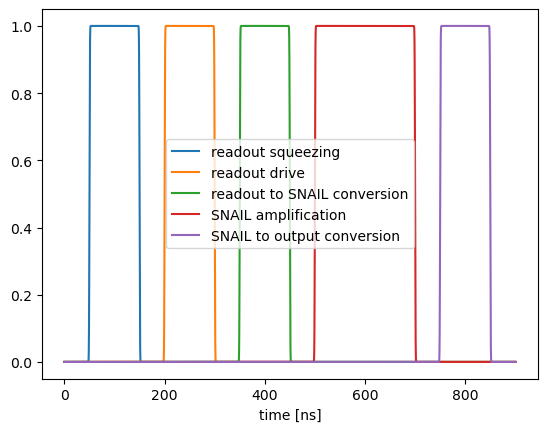

In [ ]:
# view pulses
def view_pulses(timings):
      Npulses = np.shape(timings)[0]
      t0 = timings[0,0]
      tf = timings[Npulses-1,1]
      t = np.linspace(t0-50*ns, tf+200*ns, 10000)
      for i in range(Npulses):
            t0p, tp, label = timings[i]
            plt.plot(t, gaussian_pulse(t, t0p, tp), label=label)
      plt.xlabel('time [ns]')
      plt.legend()
      plt.show()

Npulses = 5
timings = np.zeros((Npulses, 3), dtype=object)
timings[0] = t0a, ta, 'readout squeezing'
timings[1] = t0d, td, 'readout drive'
timings[2] = t0as, tas, 'readout to SNAIL conversion'
timings[3] = t0s, ts, 'SNAIL amplification'
timings[4] = t0sb, tsb, 'SNAIL to output conversion'

view_pulses(timings)

In [ ]:
# qVarName=["a1","b1","s1","a1D","b1D","s1D","Ca1a1","Ca1b1","Ca1s1","Cb1b1","Cb1s1","Cs1s1","Ca1Da1","Ca1Db1","Ca1Ds1","Cb1Da1",
      # "Cb1Db1","Cb1Ds1","Cs1Da1","Cs1Db1","Cs1Ds1","Ca1Da1D","Ca1Db1D","Ca1Ds1D","Cb1Db1D","Cb1Ds1D","Cs1Ds1D"]

# Simulation parameters

# timing parameters
tS = 0.01*ns
timesteps = int(np.round((tF-t0)/tS))+1
print(f'integrating for {timesteps} timesteps')
# timesteps = 10000
# tS = tF-t0/timesteps
T = np.linspace(t0, tF, timesteps)

# Total no. of modes
Nop = 3

# Number of readout operators
Nw = 2

# Initial condition
y0 = np.zeros(3*Nop + 2*(Nop**2))  # 9+2*9 = 3*9 = 27. <-- correct length

# time-independent hamiltonian parameters
X = 3 * MHz
phia = np.pi
phis = np.pi
thetaas = 0
thetasb = 0
gammaa = 0.1 * MHz
gammas = 1 * MHz
gammab = 20 * MHz

# time-dependent hamiltonian parameters
ra = 6 * MHz
etad = 20 * MHz
gas = 10 * MHz
rs = 4 * MHz
gsb = 10 * MHz

tparams = np.zeros((5,timesteps))
# ra pulse 
tparams[0,:] = ra * gaussian_pulse(T, t0a, ta)
# etad pulse 
tparams[1,:] = etad * gaussian_pulse(T, t0d, td)
# gas pulse
tparams[2,:] = gas * gaussian_pulse(T, t0as, tas)
# rs pulse
tparams[3,:] = rs * gaussian_pulse(T, t0s, ts)
# gsb pulse
tparams[4,:] = gsb * gaussian_pulse(T, t0sb, tsb)

# state-defining parameters
stateParams = np.array([[X], [-X]]) # for up and down states ie. +/- X dispersive shift

# Number of states to distinguish
C = np.shape(stateParams)[0]

# Number of trajectories to simulate
NTraj = 100

# # Storage arrays for quantum trajectories
# qsMatC  = np.zeros((NTraj,C,3,timesteps), dtype=complex)
# qnpMatC = np.zeros((NTraj,C,3,timesteps), dtype=complex)

# Storage array for raw heterodyne measurement records
JMat = np.zeros((NTraj,C,2,timesteps), dtype=complex)  # axis 0: trajectory index, axis 1: state index, axis 2: I vs Q, axis 3: timestep

# Storage array for moments of each mode
a_moments = np.zeros((NTraj,C,5,timesteps))     # 5 momemts: a, aD, aDa, aa, aDaD
s_moments = np.zeros((NTraj,C,5,timesteps))
b_moments = np.zeros((NTraj,C,5,timesteps))

# Loop over states
sT = time.time()
for q in range(C):

    # Extract parameters defining this state
    X = stateParams[q,0]
    print(f'X: {np.shape(X)}')

    # Assemble parameters for this state
    params = [X, phia, phis, thetaas, thetasb, gammaa, gammas, gammab, Nop, Nw]

    # Simulate NTraj trajectories
    for n in range(NTraj):
            
            # Simulate
            sol, T, qVarName, dwTraj = solveSTEOMS(params, tparams, y0, t0, tF, tS)

            # # Store results for QS dynamics
            # qsMatC[n,q,0,:] = sol[:,qVarName.index('a1')]
            # qsMatC[n,q,1,:] = sol[:,qVarName.index('Ca1a1')]
            # qsMatC[n,q,2,:] = sol[:,qVarName.index('Ca1Da1')]

            # # Store results for QNP dynamics
            # qnpMatC[n,q,0,:] = sol[:,qVarName.index('b1')]
            # qnpMatC[n,q,1,:] = sol[:,qVarName.index('Cb1b1')]
            # qnpMatC[n,q,2,:] = sol[:,qVarName.index('Cb1Db1')]

            # Store results for mode a moments
            a_moments[n,q,0,:] = sol[:,qVarName.index('a1')]
            a_moments[n,q,1,:] = sol[:,qVarName.index('a1D')]
            a_moments[n,q,2,:] = sol[:,qVarName.index('a1Da1')]
            a_moments[n,q,3,:] = sol[:,qVarName.index('a1a1')]
            a_moments[n,q,4,:] = sol[:,qVarName.index('a1Da1D')]

            # Store results for mode s moments
            s_moments[n,q,0,:] = sol[:,qVarName.index('s1')]
            s_moments[n,q,1,:] = sol[:,qVarName.index('s1D')]
            s_moments[n,q,2,:] = sol[:,qVarName.index('s1Ds1')]
            s_moments[n,q,3,:] = sol[:,qVarName.index('s1s1')]
            s_moments[n,q,4,:] = sol[:,qVarName.index('s1Ds1D')]

            # Store results for mode b moments
            b_moments[n,q,0,:] = sol[:,qVarName.index('b1')]
            b_moments[n,q,1,:] = sol[:,qVarName.index('b1D')]
            b_moments[n,q,2,:] = sol[:,qVarName.index('b1Db1')]
            b_moments[n,q,3,:] = sol[:,qVarName.index('b1b1')]
            b_moments[n,q,4,:] = sol[:,qVarName.index('b1Db1D')]

            # Store raw heterodyne measurement records
            JMat[n,q,0,:] = np.real( np.sqrt(gammab/2)*(     sol[:,qVarName.index('b1')] +    sol[:,qVarName.index('b1D')]  ) + dwTraj[:,0]/tS )
            JMat[n,q,1,:] = np.real( np.sqrt(gammab/2)*( -1j*sol[:,qVarName.index('b1')] + 1j*sol[:,qVarName.index('b1D')]  ) + dwTraj[:,1]/tS )

            if n == 50:
                  print('halfway done')

eT = time.time()
min = (eT-sT)/60-(eT-sT)%60
print(f"Done simulating TEOMs! Elapsed time: {min} min {(eT-sT)-min} seconds")

/var/folders/4c/h5552fg94xvbgxj165mnd36w0000gn/T/ipykernel_27641/3533487089.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  tparams[0,:] = ra * gaussian_pulse(T, t0a, ta)
/var/folders/4c/h5552fg94xvbgxj165mnd36w0000gn/T/ipykernel_27641/3533487089.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  tparams[1,:] = etad * gaussian_pulse(T, t0d, td)
/var/folders/4c/h5552fg94xvbgxj165mnd36w0000gn/T/ipykernel_27641/3533487089.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  tparams[2,:] = gas * gaussian_pulse(T, t0as, tas)
/var/folders/4c/h5552fg94xvbgxj165mnd36w0000gn/T/ipykernel_27641/3533487089.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  tparams[3,:] = rs * gaussian_pulse(T, t0s, ts)
/var/folders/4c/h5552fg94xvbgxj165mnd36w0000gn/T/ipykernel_27641/3533487089.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  tparams

X: ()
X: ()
Done simulating TEOMs! Elapsed time: 11148.634200811386


/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


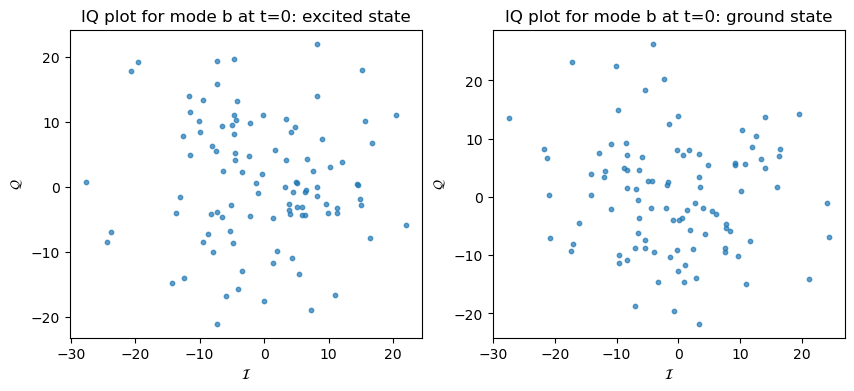

In [98]:
# Extract data for b mode at t=0
I_data_up = JMat[:, 0, 0, 0]
Q_data_up = JMat[:, 0, 1, 0]
I_data_down = JMat[:, 1, 0, 0]
Q_data_down = JMat[:, 1, 1, 0]

fig, axs = plt.subplots(1, 2, figsize=(10,4))

ax = axs[0]
ax.scatter(I_data_up, Q_data_up, s=10, alpha=0.7)
ax.set_title(r'IQ plot for mode b at t=0: excited state')
ax.set_ylabel(r'$\mathcal{Q}$')
ax.set_xlabel(r'$\mathcal{I}$')

ax = axs[1]
ax.scatter(I_data_down, Q_data_down, s=10, alpha=0.7)
ax.set_title(r'IQ plot for mode b at t=0: ground state')
ax.set_ylabel(r'$\mathcal{Q}$')
ax.set_xlabel(r'$\mathcal{I}$')

plt.show()


In [ ]:
# time dynamics of IQ plot
for t in range(timesteps):
    I_data_up = JMat[:, 0, 0, t]
    Q_data_up = JMat[:, 0, 1, t]
    I_data_down = JMat[:, 1, 0, t]
    Q_data_down = JMat[:, 1, 1, t]

    window = 30

    plt.figure(t)
    plt.scatter(I_data_up, Q_data_up, s=10, alpha=0.7, color='blue', label='up')
    plt.scatter(I_data_down, Q_data_down, s=10, alpha=0.7, color='orange', label='down')
    plt.title(f'mode b at t={t}')
    plt.ylabel(r'$\mathcal{Q}$')
    plt.xlabel(r'$\mathcal{I}$')
    plt.xlim(-window,window)
    plt.ylim(-window,window)
    plt.legend(loc='upper left')
    # fig, axs = plt.subplots(1, 2, figsize=(10,4))

    # ax = axs[0]
    # ax.scatter(I_data_up, Q_data_up, s=10, alpha=0.7, color='blue')
    # ax.set_title(r'IQ plot for mode b at t=0: excited state')
    # ax.set_ylabel(r'$\mathcal{Q}$')
    # ax.set_xlabel(r'$\mathcal{I}$')
    # ax.set_xlim(-30,30)
    # ax.set_ylim(-30,30)

    # ax = axs[1]
    # ax.scatter(I_data_down, Q_data_down, s=10, alpha=0.7, color='orange')
    # ax.set_title(r'IQ plot for mode b at t=0: ground state')
    # ax.set_ylabel(r'$\mathcal{Q}$')
    # ax.set_xlabel(r'$\mathcal{I}$')
    # ax.set_xlim(-30,30)
    # ax.set_ylim(-30,30)

    plt.savefig(f'gifs/EA_IQ_evolution/slice_{t}.png')
plt.close('all')


/var/folders/4c/h5552fg94xvbgxj165mnd36w0000gn/T/ipykernel_27641/3255598190.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(t)


/var/folders/4c/h5552fg94xvbgxj165mnd36w0000gn/T/ipykernel_27641/1623603940.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in png_files]



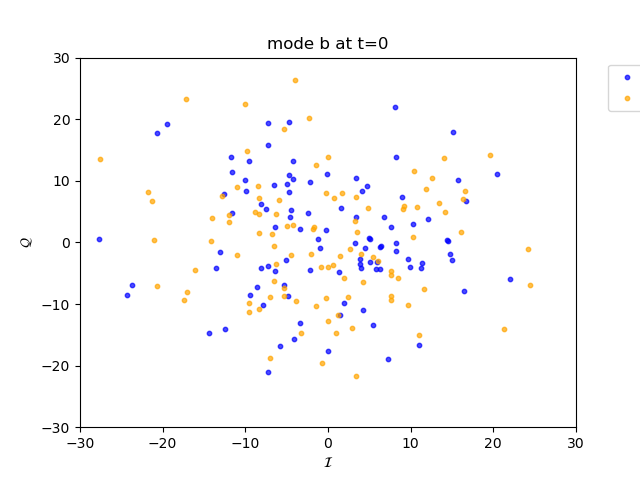

In [ ]:
# Gather all PNGs in order
png_files = sorted(glob.glob("gifs/EA_IQ_evolution/slice_*.png"))

# Create GIF
gif_path = "gifs/EA_IQ_evolution/time-dep-H-IQ-dynamics.gif"
images = [imageio.imread(f) for f in png_files]
imageio.mimsave(gif_path, images, fps=5)  # adjust fps

# encode as base64 and embed
with open(gif_path, "rb") as f:
    data = f.read()
data_url = "data:image/gif;base64," + base64.b64encode(data).decode()
HTML(f'<img src="{data_url}" width="600">')

# MAKE ALL IQ PLOTS< AND TIME DYNAMICS (PNG), AND TRY RUNNING ON DELLA FROM VSCODE


In [ ]:
# get moments of mode a at t=0


In [ ]:
# # Plot quantum trajectories 
# fig, axs = plt.subplots(1, 4, figsize=(20,4))

# # Trajectory to plot
# npl = 0

# ax = axs[0]
# for q in range(C):
#     cStr = 'C' + str(q)
#     ax.plot(T, np.abs(qsMatC[npl,q,0,:]), c=cStr)

# ax.set_xlabel(r'$t$')
# ax.set_title(r'QS $|\langle a \rangle_c|$')

# ax = axs[1]
# for q in range(C):
#     cStr = 'C' + str(q)
#     ax.plot(T, np.abs(qsMatC[npl,q,0,:]), c=cStr)

# ax.set_ylim([13.5,14.5])
# ax.set_xlabel(r'$t$')
# ax.set_title(r'QS $|\langle a \rangle_c|$, zoom')

# ax = axs[2]
# for q in range(C):
#     cStr = 'C' + str(q)
#     ax.plot(T, np.abs(qnpMatC[npl,q,0,:]), c=cStr)

# ax.set_xlabel(r'$t$')
# ax.set_title(r'QNP $|\langle b \rangle_c|$')

# # Zoom in at long time limit
# ax = axs[3]
# for q in range(C):
#     cStr = 'C' + str(q)
#     ax.plot(T, np.abs(qnpMatC[npl,q,0,:]), c=cStr)

# ax.set_ylim([8.5,9.5])
# ax.set_xlabel(r'$t$')
# ax.set_title(r'QNP $|\langle b \rangle_c|$, zoom')

# plt.show()

/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


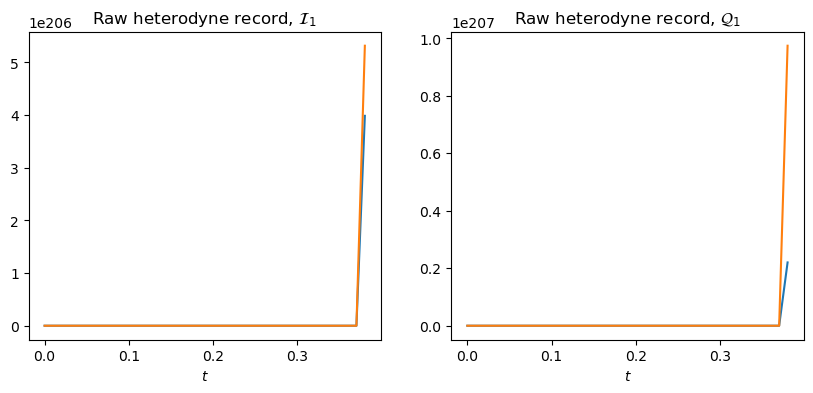

In [13]:
# Plot quantum trajectories and raw heterodyne records
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Trajectory to plot
npl = 0

ax = axs[0]
for q in range(C):
    cStr = 'C' + str(q)
    ax.plot(T, JMat[npl,q,0,:], c=cStr)

ax.set_title(r'Raw heterodyne record, $\mathcal{I}_1$')
ax.set_xlabel(r'$t$')

ax = axs[1]
for q in range(C):
    cStr = 'C' + str(q)
    ax.plot(T, JMat[npl,q,1,:], c=cStr)

ax.set_title(r'Raw heterodyne record, $\mathcal{Q}_1$')
ax.set_xlabel(r'$t$')

plt.show()

/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


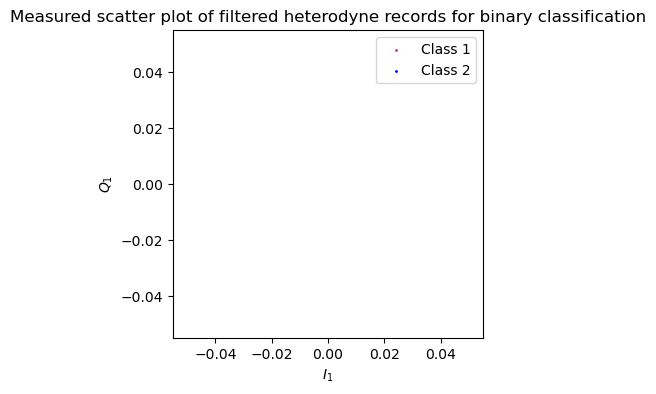

In [14]:
# Post-processing

# Storage array for filtered heterodyne measurement records
IMat = np.zeros((NTraj,C,2), dtype=complex)

for q in range(C):
    for n in range(NTraj):
        IMat[n,q,0] = np.sum(JMat[n,q,0,:])/len(T)
        IMat[n,q,1] = np.sum(JMat[n,q,1,:])/len(T)

# Scatter plot of filtered heterodyne measurement records
fig, ax = plt.subplots(1, 1, figsize=(4,4))

mycolors=['deeppink','blue']
for q in range(C):
    cStr = 'C' + str(q)
    ax.scatter(IMat[:,q,0],IMat[:,q,1], s=1, color=mycolors[q])#cStr)

ax.set_title('Measured scatter plot of filtered heterodyne records for binary classification')
ax.set_xlabel(r'$I_1$')
ax.set_ylabel(r'$Q_1$')

ax.legend(['Class 1', 'Class 2'])

plt.show()